# List of planets with mass and distance, Center of Mass for each system
### 1. read the file from exoplanet.eu
List of planets from exoplanet.eu, it is taking mass (and its uncertaintly), semi_major (and its uncertaintly), Metallicity (and its uncertaintly).  

In [1]:
import pandas as pd 
import numpy as np
from scipy.stats import norm # normal distribution
import random
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

%matplotlib inline
#%matplotlib qt
data_ep = pd.read_csv('data/exoplanet.eu_catalog.csv', 
                      usecols=['mass','mass_error_min','semi_major_axis',
                               'semi_major_axis_error_min','star_name',
                               'star_metallicity','star_metallicity_error_min'])

data_ep = data_ep.replace([np.inf, -np.inf], np.nan) # it replaces the inf values
#data_ep
#data_ep.count()

**Remember**: `pd.notnull("name_of_column")` deletes the NaN values in the column. 

**Remember**: `data=data[['column_a','column_b',..,'column_n',]]` to get a new order in the DataFrame

Now is necessary processing the data with the prurpose to obtain the Center of Mass CM, `data1` is a DataFrame without the NaN values of _mass_ and _semi major axis_. Finally, we get 1667 rows.

In [2]:
dataB = data_ep.dropna(subset=['mass','mass_error_min','semi_major_axis',
                               'semi_major_axis_error_min'])
#-----------------------------------------------------------------------
data2 = dataB[['star_name','mass', 'mass_error_min',
               'semi_major_axis','semi_major_axis_error_min']]
#-----------------------------------------------------------------------
print(len(data2))

1217


So, `data2` is a DataFrame without the NaN values of mass, semi major axis and their uncertainties. Finally, we get 1217 rows, 445 rows less than `data1`. 

For the semi major axes column, withouth NaN values we have `data3`, it is usefull for planetary systems with one planet observed.

### 2. Center of Mass 
We need to estimate the CM for each planet, so:
\begin{equation*}
\text{CM} = \frac{\sum\limits_{k=1}^n(m_{k}\vec{r_{k}})}{\sum \limits_{k=1}^{n}m_{k}} %=\frac{\sum\limits_{k=1}^n(m_{k}\vec{r_{k}})}{M_{T}}
\end{equation*}
For do it, is nessesary get the values CM for each planet, so with the columns of `mass` and distance from the star  `semi_major_axis` we can get $\boxed{m_{k}\vec{r_{k}}}$ values.

**Remember:** The `data.groupby("key")` split the data in groups which are the key.

**Remember:** The `data[i].multiply(data[j])` multiplies the comun i and j of DataFrame or Series i and j, row by row.

**Remember:** The `data.groupby.groups.keys()` get the keys of the split data.

#### Employing  `data2`: #### 

In [3]:
r_i = data2["semi_major_axis"]
m_i = data2["mass"]
#----------------------------------------------------------------------
#the multiplications between columns, new column CM_i:
data2 = data2.assign(CM_i=r_i.multiply(m_i))  
#----------------------------------------------------------------------
#value, for each planet in the system. 
p_system = data2.groupby("star_name")
#----------------------------------------------------------------------
#(np.isnan(data1.CM_i)).sum()

However, the calculus of the CM, counting the planetary systems with the same satar. 

### 3. Gaussian Mixture Model
#### Center of Mass
The Gaussian Mixture model: 

In [4]:
#The total mass, for each system: 
M_total = p_system["mass"].sum()#.tolist() changes from Series to list
#----------------------------------------------------------------------
#The sum of the CM_i for each system:
sum_rm = p_system['CM_i'].sum()#.tolist()
#----------------------------------------------------------------------
#total center of mass, for each extraplanetary system
CM = sum_rm.divide(M_total)
#----------------------------------------------------------------------
system = list(p_system.groups.keys())
#system
#----------------------------------------------------------------------
#the data after get the Center of Mass for each system 
data = pd.DataFrame({'system_name':system,
                     'total_mass':M_total.tolist(),
                     'center_of_Mass':CM.tolist()})
#len(data1) 
#(np.isnan(data1.center_of_Mass)).sum()

In [5]:
len(data[["center_of_Mass"]])

987

Text(0.5, 0, 'Center Of Mass (AU)')

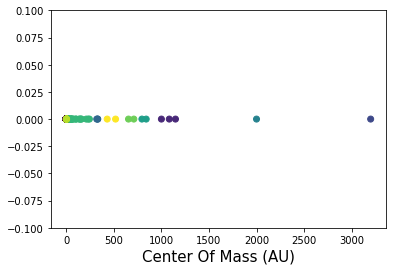

In [6]:
#GaussianMixture:  a firs approximation for 10 grups
#----------------------------------------------------------------------
gmm = GaussianMixture(10, covariance_type='full', random_state=0)
CM=data[["center_of_Mass"]]
gmm.fit(CM.values)
cluster_label = gmm.predict(CM.values)
plt.scatter((CM.values),np.zeros(len(CM)), c=cluster_label);
plt.ylim(-0.1,0.1)
plt.xlabel(r"Center Of Mass (AU)", fontsize="15")
#For the CoM is nessesary emply a Logarithm sclae.

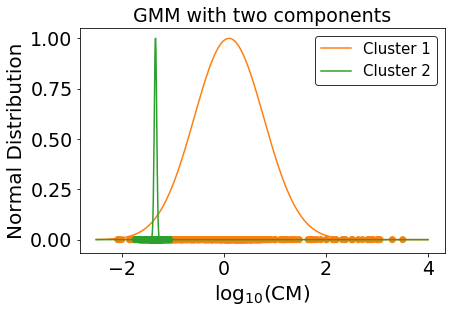

In [7]:
#the log10scale for center of mass of each exoplanetary system:
#----------------------------------------------------------------------
CM_log=np.log10(data[["center_of_Mass"]])

GMM,cluster=[],[]

#Some different components for Gaussian Mixture Model: 
#----------------------------------------------------------------------
for i in [2,3]:
    gmm = GaussianMixture(i, covariance_type='full', random_state=0)
    GMM.append(gmm)
    gmm.fit(CM_log.values)
    cluster_label = gmm.predict(CM_log.values)
    cluster.append(cluster_label)

# (just a plot for two grups)
#----------------------------------------------------------------------
#plt.rc('text', usetex=True)

color=[]
#len(cluster[0])
for i in range(len(cluster[0])):
    if cluster[0][i] == 0:
        color.append("C1")
    elif cluster[0][i] == 1:
        color.append("C2")

x=np.linspace(-2.5,4,1000)
colors=["C1","C2","C3","C4","C5"]

fig, ax1 = plt.subplots(1, 1, sharex='col', sharey='row')

plt.gcf().subplots_adjust(bottom=0.15,right=0.96, left=0.115, top=0.93)

for i, (v1,v2) in enumerate(zip(GMM[0].means_,GMM[0].covariances_)):
    ax1.plot(x, norm.pdf(x,v1,v2)[0]/norm.pdf(x,v1,v2)[0].max(),
             c=colors[i],label="Cluster "+str(i+1))
    ax1.legend(fontsize=15,edgecolor='black')

ax1.scatter((CM_log.values),np.zeros(len(CM_log)),c=color, label="Group 1")  

ax1.tick_params(labelsize=19)

plt.title(r"GMM with two components",fontsize=19)
plt.xlabel(r'$\log_{10}$(CM)',fontsize=20)
plt.ylabel(r'Normal Distribution',fontsize=20)
#plt.savefig("figures/GMM2.pdf")

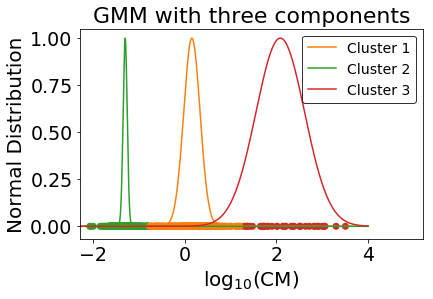

In [8]:
# (just a plot for five grups)
#----------------------------------------------------------------------
color=[]
C = cluster[1]
for i in range(len(cluster[1])):
    if C[i] == 0:
        color.append("C1")
    elif C[i] == 1:
        color.append("C2")
    elif C[i] == 2:
        color.append("C3")
    elif C[i] == 3:
        color.append("C4")
    elif C[i] == 4:
        color.append("C5")

x=np.linspace(-2.5,4,1000)
colors=["C1","C2","C3","C4","C5"]

fig2, ax2 = plt.subplots(1, 1, sharex='col', sharey='row')

plt.gcf().subplots_adjust(bottom=0.17,right=0.97, left=0.175, top=0.90)

for i, (v1,v2) in enumerate(zip(GMM[1].means_,GMM[1].covariances_)):
    ax2.plot(x, norm.pdf(x,v1,v2)[0]/norm.pdf(x,v1,v2)[0].max(),
             c=colors[i],label="Cluster "+str(i+1))
    ax2.legend(fontsize=14, loc=1,edgecolor='black')

ax2.scatter((CM_log.values),np.zeros(len(CM_log)),c=color, label="Group 1")  
ax2.set_xlim(-2.3,5.2)

ax2.tick_params(labelsize=19)

plt.title(r"GMM with three components",fontsize=22)
plt.xlabel(r'$\log_{10}$(CM)',fontsize=20)
plt.ylabel(r'Normal Distribution',fontsize=20)
#plt.savefig("figures/GMM3.pdf")

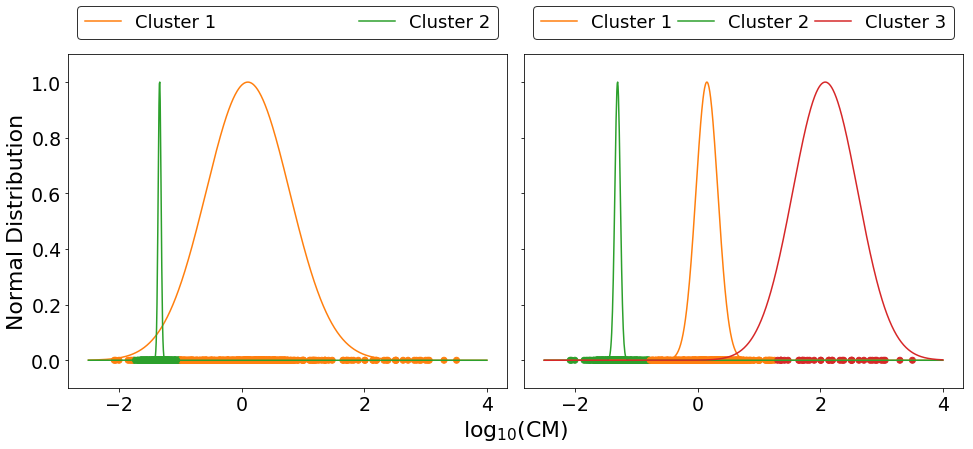

In [10]:
col=[]
#len(cluster[0])
for i in range(len(cluster[0])):
    if cluster[0][i] == 0:
        col.append("C1")
    elif cluster[0][i] == 1:
        col.append("C2")

lor=[]
C = cluster[1]
for i in range(len(cluster[1])):
    if C[i] == 0:
        lor.append("C1")
    elif C[i] == 1:
        lor.append("C2")
    elif C[i] == 2:
        lor.append("C3")
    elif C[i] == 3:
        lor.append("C4")
    elif C[i] == 4:
        lor.append("C5")        
        
x=np.linspace(-2.5,4,1000)
colors=["C1","C2","C3","C4","C5"]

fig, axs = plt.subplots(1, 2, figsize=(13.5, 6.1), sharey=True)

plt.gcf().subplots_adjust(bottom=0.12,right=0.99, left=0.07, top=0.88)

axs[0].scatter((CM_log.values),np.zeros(len(CM_log)),c=col)  
axs[1].scatter((CM_log.values),np.zeros(len(CM_log)),c=lor)  

for i, (v1,v2) in enumerate(zip(GMM[0].means_,GMM[0].covariances_)):
    axs[0].plot(x, norm.pdf(x,v1,v2)[0]/norm.pdf(x,v1,v2)[0].max(),
             c=colors[i],label="Cluster "+str(i+1))
    axs[0].legend(fontsize=18,edgecolor='black',bbox_to_anchor=(-0, 1.02, 1, .15), loc=3,
           ncol=2,mode="expand")

for i, (v1,v2) in enumerate(zip(GMM[1].means_,GMM[1].covariances_)):
    axs[1].plot(x, norm.pdf(x,v1,v2)[0]/norm.pdf(x,v1,v2)[0].max(),
             c=colors[i],label="Cluster "+str(i+1))
    axs[1].legend(fontsize=18,edgecolor='black',bbox_to_anchor=(0, 1.02, 1, .102), loc=3,
           ncol=3, mode="expand")
    
axs[0].set_ylim(-0.1,1.1,1/10)

axs[0].tick_params(labelsize=19)
axs[1].tick_params(labelsize=19)
plt.subplots_adjust(wspace=0.04)

#axs.xlabel(r'$\log_{10}$(CM)',fontsize=20)
axs[0].set_ylabel(r'Normal Distribution',fontsize=22)
fig.text(0.53, 0.025, r"$\log_{10}$(CM)", fontsize=22, ha='center', va='center')

#plt.savefig("figures/GMM2-4.pdf")

To determine the number of cluster in the Gaussian Mixture Model, it may use a bayessian information criterion

In [11]:
#Bayesian information criterion 
bic=[]
for i in range(10):
    i+=1
    gmm = GaussianMixture(i, covariance_type='full', random_state=0)
    CM_log=np.log10(data[["center_of_Mass"]])
    gmm.fit(CM_log.values)
    bic+=[gmm.bic(CM_log.values)]
#bic

In [12]:
min(bic)

2057.8852592352655

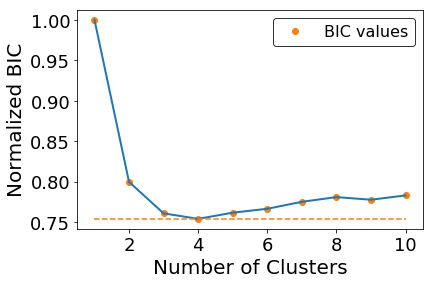

In [41]:
# (just a plot to bayessian criterion)
#----------------------------------------------------------------------

#fig = plt.figure(figsize=(4,3))
#plt.plot(range(1,11),bic)

fig3, ax3 = plt.subplots(1, 1, sharex='col', sharey='row')

plt.gcf().subplots_adjust(bottom=0.19,right=0.98, left=0.18, top=0.95)

f = ax3.plot(range(1,11),bic/max(bic), "o", c="C1",label="BIC values")
h = ax3.plot(range(1,11),bic/max(bic), lw="2")
g = ax3.plot(range(1,11),np.ones(len(bic))*min(bic)/max(bic),"--")

ax3.set_xlim(0.5,10.5)
ax3.tick_params(labelsize=18)
ax3.legend(fontsize=16, loc=1,edgecolor='black')

ax3.set_yticks(range(0,1),1/10)

#plt.title(r"Bayessian Information Criterion",fontsize=16)
plt.xlabel(r'Number of Clusters',fontsize=20)
plt.ylabel(r'Normalized BIC',fontsize=20)
#plt.savefig("figures/BIC.pdf")

(-0.1, 1)

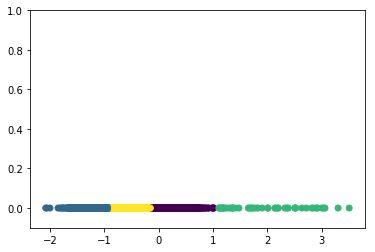

In [14]:
# GaussianMixture, for the log of CM: 
# 4 groups due tu the bic
gmm = GaussianMixture(4, covariance_type='full', random_state=0)
CM_log=np.log10(data[["center_of_Mass"]])
gmm.fit(CM_log.values)
cluster_label = gmm.predict(CM_log.values)
plt.scatter((CM_log.values),np.zeros(len(CM_log)),c=cluster_label);
plt.ylim(-0.1,1)

The probabilities or verisimilitudes, are defined by normal distribution for each group from the gaussian mixture model:

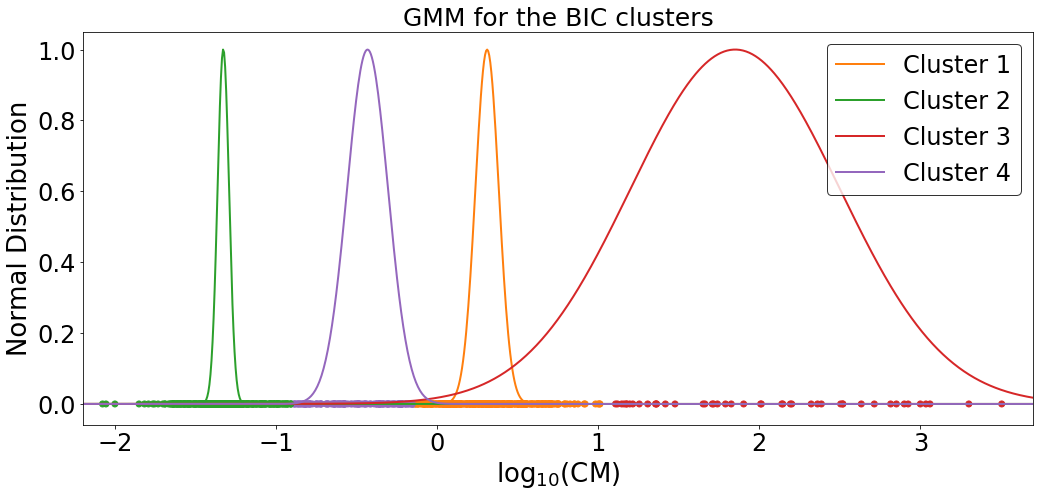

In [34]:
#gmm.means_
#just a plot to bayessian criterion for 4 clusters 
#----------------------------------------------------------------------
plt.figure(figsize=(15,7))
plt.gcf().subplots_adjust(bottom=0.15,right=0.96, left=0.08, top=0.93)

color=[]
CL = cluster_label
for i in range(len(cluster[1])):
    if CL[i] == 0:
        color.append("C1")
    elif CL[i] == 1:
        color.append("C2")
    elif CL[i] == 2:
        color.append("C3")
    elif CL[i] == 3:
        color.append("C4")
    elif CL[i] == 4:
        color.append("C5")
        
colors=["C1","C2","C3","C4","C5"]

#fig4, ax4 = plt.subplots(1, 1, sharex='col', sharey='row')

for i, (v1,v2) in enumerate(zip(gmm.means_,gmm.covariances_)):
    plt.plot(x, norm.pdf(x,v1,v2)[0]/norm.pdf(x,v1,v2)[0].max(),
             c=colors[i],label="Cluster "+str(i+1),lw=2)
    plt.legend(fontsize=24, loc=1,edgecolor='black')

plt.scatter((CM_log.values),np.zeros(len(CM_log)),c=color, label="Group 1")  
plt.xlim(-2.2,3.7)

plt.tick_params(labelsize=24)

plt.title(r"GMM for the BIC clusters",fontsize=25)
plt.xlabel(r'$\log_{10}$(CM)',fontsize=26)
plt.ylabel(r'Normal Distribution',fontsize=26)
#plt.savefig("figures/GMM4.pdf") 

The posteriror probabilities are determinated by the function `gmm.predict_proba()`

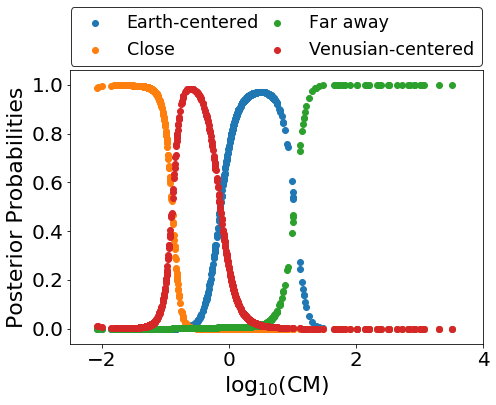

In [137]:
# The posterior probabilities: 
names=["Earth-centered", "Close","Far away","Venusian-centered"]
plt.figure(figsize=(7,5.6))

for i in range(4):
    plt.scatter(CM_log,gmm.predict_proba(CM_log)[:,i],label=names[i]);

plt.gcf().subplots_adjust(bottom=0.15,right=0.97, left=0.15, top=0.83)
plt.tick_params(labelsize=20)    
plt.xlabel(r'$\log_{10}$(CM)',fontsize=22)
plt.ylabel(r'Posterior Probabilities',fontsize=22)
plt.xlim(-2.5,4)
plt.legend(fontsize=17.5,edgecolor='black', 
           bbox_to_anchor=(-0.02, 1.20, 1.037, 0.06), loc=2,
           ncol=2, mode="expand")
#plt.savefig("figures/Prob.pdf")

The probability for a synthetic draw of a system called AA, with a $\mu=0.8$ and $\sigma=0.03$ in the CM, can be established as:

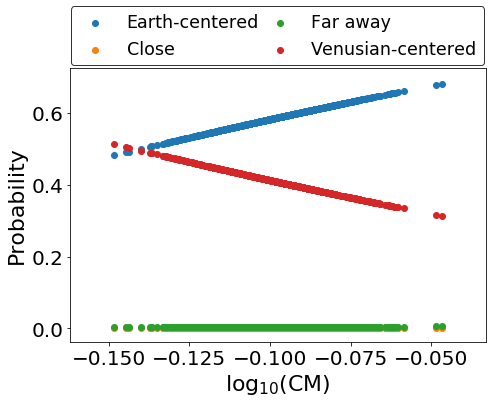

In [177]:
AA=np.log10(np.random.normal(0.8,0.03,1000))
AA=AA[:,np.newaxis]
names=["Earth-centered", "Close","Far away","Venusian-centered"]
plt.figure(figsize=(7,5.6))

#production of probability for a syntethic planetary system 
for i in range(4):
    plt.scatter(AA,gmm.predict_proba(AA)[:,i],label=names[i])

plt.gcf().subplots_adjust(bottom=0.15,right=0.965, left=0.14, top=0.83)
plt.legend(fontsize=17.5,edgecolor='black', 
           bbox_to_anchor=(-0.02, 1.20, 1.037, 0.055), loc=2,
           ncol=2, mode="expand")
plt.tick_params(labelsize=20)    
plt.xlabel(r'$\log_{10}$(CM)',fontsize=22)
plt.ylabel(r'Probability',fontsize=22)
#plt.savefig("figures/draw.pdf")

## ... Draws
Employing m and $\Delta$m, a and $\Delta$a, from `data2`.

In [92]:
# Group the planetary system:
Planetary_System = data2.groupby("star_name")
Systems_List = list(Planetary_System.groups.keys())

A first way to get the drows for each system:

In [180]:
#%%time
#-------------------------------------------------------------------------
# Drows, for each planetary system
draws=[]#drows of COM for each system. 
for i in range(len(Systems_List)):
    system_i = data2[data2.star_name == Systems_List[i]]    
    draw_i=[]
    for j in  range(1000):
        #Get random values for each planet in a system and the COM for those values
        masses=np.random.normal(system_i.mass,system_i.mass_error_min)
        axes=np.random.normal(system_i.semi_major_axis,
                              system_i.semi_major_axis_error_min)
        draw_i += [(masses*axes).sum()/masses.sum()]
    draws.append(draw_i)


Second way to get the draws for each system (in a shorter time):

In [189]:
#%%time
DrawsA=[]#drows of COM for each system. 
for i in range(len(Systems_List)):
    SystemA_i = data2[data2.star_name == Systems_List[i]]  
    Mass_System = np.zeros(1000)
    Mass_Axe = np.zeros(1000) 
    for k in range(len(SystemA_i)):
        Masses = np.random.normal(SystemA_i.mass.values[k],
                                  SystemA_i.mass_error_min.values[k],1000)
        Axes = np.random.normal(SystemA_i.semi_major_axis.values[k],
                                SystemA_i.semi_major_axis_error_min.values[k],
                                1000)
        Mass_Axe += Masses*Axes
        Mass_System += Masses
        #print(SystemA_i.mass.values[k])
    DrawsA.append([np.abs(Mass_Axe/Mass_System)])
len(DrawsA)

987

In [190]:
SystemA_i = data2[data2.star_name == Systems_List[2]]  
SystemA_i
#type(DrawsA[2][0])#[987)

,star_name,mass,mass_error_min,semi_major_axis,semi_major_axis_error_min,CM_i
0,11 Com,19.4,1.5,1.29,0.05,25.026


(array([  4.,  11.,  70., 167., 265., 257., 152.,  55.,  17.,   2.]),
 array([-1.96410187, -0.77923875,  0.40562437,  1.59048749,  2.77535061,
         3.96021373,  5.14507686,  6.32993998,  7.5148031 ,  8.69966622,
         9.88452934]),
 <a list of 10 Patch objects>)

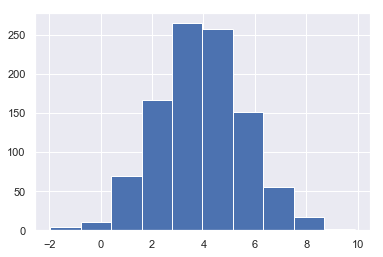

In [191]:
plt.hist(np.random.normal(3.9,1.7,1000))

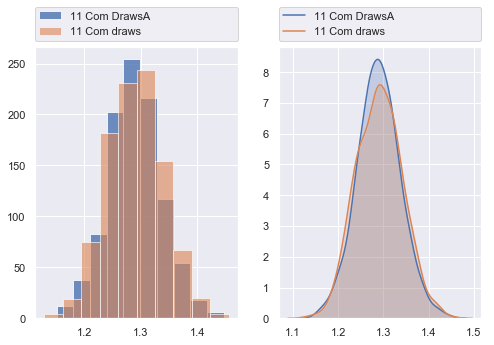

In [192]:
#import seaborn as sns
#sns.set()
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))

f1 = ax1.hist(DrawsA[2][0],10,alpha=0.8,label=Systems_List[2]+" DrawsA")
f2 = ax1.hist(draws[2],10, alpha=0.6,label=Systems_List[2]+" draws")
ax1.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,ncol=1, mode="expand", borderaxespad=0.)
f2 = sns.kdeplot(DrawsA[2][0], shade=True,label=Systems_List[2]+" DrawsA")
f3 = sns.kdeplot(draws[2], shade=True,label=Systems_List[2]+" draws")
ax2.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,ncol=1, mode="expand", borderaxespad=0.)

The probability of each draw to belong a each group, taking draws form `DrawsA`

0
0.021


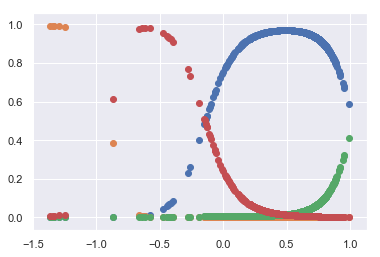

In [216]:
kk=8
Draw_i=np.log10(DrawsA[kk][0][:,np.newaxis])
orig=gmm.predict(np.array(CM_log))[kk]
print(orig)
print((orig!=gmm.predict(Draw_i)).sum()/1000)
for i in range(4):
    plt.scatter(Draw_i,gmm.predict_proba(Draw_i)[:,i])

In [204]:
np.log10(DrawsA[8])[0][:10]

array([ 0.15867423,  0.45984595,  0.58636254,  0.49191756,  0.64982826,
        0.57226101,  0.77417569,  0.44202075, -0.6178504 , -0.03834046])

(array([  5.,   0.,   2.,   7.,   5.,  26.,  87., 250., 477., 141.]),
 array([-1.36098466, -1.12585011, -0.89071555, -0.655581  , -0.42044644,
        -0.18531188,  0.04982267,  0.28495723,  0.52009178,  0.75522634,
         0.9903609 ]),
 <a list of 10 Patch objects>)

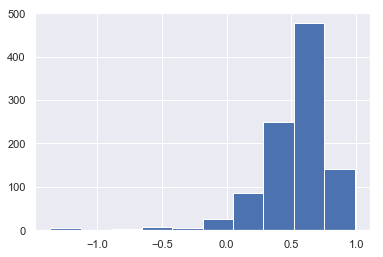

In [205]:
plt.hist(np.log10(DrawsA[8])[0])

0.8713272543059777


0.477

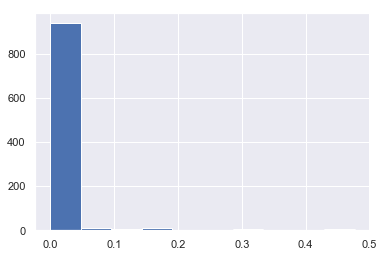

In [210]:
# CM_log is the centero of mass in log scale for each system
frac=[]
for kk in range(len(DrawsA)):
    Draw_i=np.log10(DrawsA[kk][0][:,np.newaxis])
    orig=gmm.predict(np.array(CM_log))[kk]
#    print(kk)
    frac+=[(orig!=gmm.predict(Draw_i)).sum()/1000] # AA es el elemento i de draws (que debe ser un array de 1000 elementos)


#for i in range(4):
#    plt.scatter(Draw_i,gmm.predict_proba(Draw_i)[:,i])
#orig
#AA
#orig=gmm.predict(np.array([[0.8]])) # 0.8 es el centro de masa para el sistema i
#(orig!=gmm.predict(AA)).sum()/1000 # AA es el elemento i de draws (que debe ser un array de 1000 elementos)
#DrawsA[0]
#Draw_i=DrawsA[0][0][:,np.newaxis]
#gmm.predict(Draw_i)
#Draw_i
#gmm.predict(Draw_i)
plt.hist(frac)
print((np.array(frac)==0).sum()/len(frac))
np.max(frac)

In [211]:
orig=gmm.predict(np.array(CM_log))[2]
print(CM_log.values)
DrawsA[2][0]

[[ 2.30448921e-01]
 [-3.74687549e-01]
 [ 1.10589710e-01]
 [ 2.38560627e+00]
 [ 1.87520721e-01]
 [ 4.42479769e-01]
 [ 2.25309282e-01]
 [ 2.51851394e+00]
 [ 5.91064607e-01]
 [-7.21246399e-01]
 [ 1.92681873e-01]
 [-3.62121727e-02]
 [ 1.71600334e+00]
 [ 2.19312460e+00]
 [ 1.17609126e+00]
 [ 4.61948495e-01]
 [ 1.66275783e+00]
 [ 5.47774705e-01]
 [ 6.51278014e-01]
 [ 2.36172784e+00]
 [ 2.71432976e+00]
 [-2.17691925e-03]
 [ 2.60071388e-01]
 [-6.04807474e-02]
 [ 7.55469614e-02]
 [ 7.46620979e-01]
 [ 1.14612804e+00]
 [ 6.24403853e-01]
 [-4.85225019e-01]
 [ 2.85557309e-01]
 [-3.09803920e-01]
 [-7.90484985e-01]
 [ 1.64352856e-01]
 [ 1.13943352e-01]
 [-2.39577517e-01]
 [-1.18045606e+00]
 [-6.17982957e-01]
 [-3.01029996e-01]
 [ 7.55469614e-02]
 [ 6.23249290e-01]
 [-2.24962274e-01]
 [-2.18158493e-01]
 [ 3.57934847e-01]
 [ 1.27104798e-01]
 [ 1.82607480e+00]
 [ 4.14973348e-01]
 [-2.07675598e+00]
 [-1.59516628e+00]
 [-9.76747540e-01]
 [-1.36141092e+00]
 [-1.39620630e+00]
 [-1.29242982e+00]
 [-1.5686362

array([1.30639306, 1.28650685, 1.31558285, 1.32408408, 1.31445191,
       1.27212195, 1.3157653 , 1.24596431, 1.26008969, 1.29720708,
       1.3059149 , 1.30331696, 1.28561621, 1.34124685, 1.23993865,
       1.32769018, 1.33728326, 1.3035183 , 1.30843009, 1.23938595,
       1.30364127, 1.22941843, 1.33680914, 1.26992726, 1.27362889,
       1.25463225, 1.27309492, 1.20581462, 1.27445679, 1.3079215 ,
       1.31810442, 1.24742628, 1.3154788 , 1.35241699, 1.3377995 ,
       1.19592549, 1.27775626, 1.31627234, 1.31020272, 1.27413036,
       1.16395064, 1.20445838, 1.26194556, 1.28043342, 1.25350094,
       1.25946024, 1.3456644 , 1.24236412, 1.29630213, 1.23089642,
       1.28847122, 1.27060471, 1.30669816, 1.326823  , 1.27218058,
       1.35832293, 1.33236132, 1.31161745, 1.28966639, 1.31760566,
       1.25971625, 1.26641312, 1.33320084, 1.27915814, 1.28093378,
       1.35448192, 1.30231444, 1.36328613, 1.31254092, 1.28504932,
       1.27352886, 1.36123454, 1.23668092, 1.29726283, 1.19600

#### Metallicity

In [196]:
dataMet = data_ep[pd.notnull(data_ep["star_metallicity"])]
dataMetA = dataMet[pd.notnull(dataMet["star_metallicity_error_min"])]
dataMet = dataMetA[['star_name',"star_metallicity","star_metallicity_error_min"]]

In [195]:
gmm2 = GaussianMixture(3, covariance_type='full', random_state=0)
B=dataMet[["star_metallicity"]]
gmm2.fit(B.values)
cluster_label = gmm2.predict(B.values)
B.values[:, 0]
plt.scatter((B.values),np.zeros(len(B)), c=cluster_label);
plt.ylim(-0.1,1)

NameError: name 'dataMet' is not defined

In [30]:
bic=[]
for i in range(15):
    i+=1
    gmm2 = GaussianMixture(i, covariance_type='full', random_state=0)
    A=data1[["center_of_Mass"]]
    gmm2.fit(B.values)
    bic+=[gmm2.bic(B.values)]
plt.plot(range(1,16),bic)

NameError: name 'data1' is not defined

NameError: name 'A' is not defined

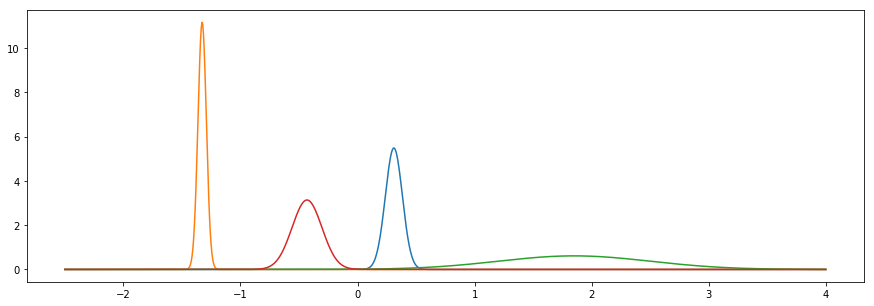

In [31]:
plt.figure(figsize=(15,5))
sma=np.linspace(-2.5,4,1000)
for m,s in zip(gmm.means_,gmm.covariances_):
    plt.plot(sma, norm.pdf(sma,m,s)[0])
plt.scatter((A.values),np.zeros(len(A)), c = cluster_label);